# Verification of the assumptions

## 1. Is Hemi-Oct area-preserving?

### Reminder
Check if the Jacobian determinant of the hemi oct is actually different from 1! If its variance is too low, the idea is useless.  This could happen as the oct mapping is designed to be area-preserving.

### Action
Wrote the following code to  numerically compute the Jacobian determinant (area distortion factor) of the Hemispherical Octahedral projection. The script maps a UV grid to spherical coordinates and calculates the magnitude of the cross product of partial derivatives ($\|\partial P/\partial u \times \partial P/\partial v\|$) to visualize where the mapping stretches or compresses relative to the texture space.

### Results
* **Assumption Verified:** The mapping is strictly **non-uniform**. The Jacobian determinant is significantly different from 1.0, ranging from $\approx 0.008$ to $\approx 2.55$. This confirms that standard uniform dithering is mathematically suboptimal.
* **Topology Discovery:** The distortion profile looks like this:
    * **Center (Pole):** $D \approx 0.6$. The mapping is *compressed* here, meaning the pole actually has higher resolution than a uniform mapping.
    * **Mid-Quadrants ("Cheeks"):** $D \approx 2.55$. These are the regions of highest expansion (lowest precision), roughly 45° from the view vector.
    * **Edges (Horizon):** $D < 0.01$. Collapse near the singularity.
* **Conclusion:** The variance is high enough to justify the research. The "Four-Peak" distribution proves that a simple radial heuristic (distance from center) would fail, validating the need for the Analytical Jacobian approach to target the specific mid-quadrant danger zones.

### Code

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def hemi_oct_decode(u, v):
    """
    Decodes Hemi-Oct coordinates (u, v in [-1, 1]) to Unit Vectors.
    Based on Cigolle et al. 2014, Listing 6.
    """
    # 1. Rotate and scale the unit square back to the center diamond
    temp_x = (u + v) * 0.5
    temp_y = (u - v) * 0.5
    
    # 2. Reconstruct the vector on the L1 sphere (octahedron)
    z = 1.0 - np.abs(temp_x) - np.abs(temp_y)
    
    vec = np.dstack((temp_x, temp_y, z))
    
    # 4. Normalize to project onto the L2 sphere
    norm = np.linalg.norm(vec, axis=2, keepdims=True)
    return vec / norm

In [7]:
def compute_tangent_vectors(res):    
    # Create UV grid [-1, 1]
    # We use a slight epsilon to avoid the exact discontinuous edges for differentiation
    u = np.linspace(-1 + 1e-4, 1 - 1e-4, res)
    v = np.linspace(-1 + 1e-4, 1 - 1e-4, res)
    U, V = np.meshgrid(u, v)

    P = hemi_oct_decode(U, V)

    
    # Compute Partial Derivatives using Central Differences (np.gradient)
    # The step size is 2.0 / (res - 1) because our domain is size 2 [-1, 1]
    step = 2.0 / (res - 1)
    
    # dP/du (gradient along axis 1)
    dPx_du, dPx_dv = np.gradient(P[:,:,0], step)
    dPy_du, dPy_dv = np.gradient(P[:,:,1], step)
    dPz_du, dPz_dv = np.gradient(P[:,:,2], step)

    
    # Construct tangent vectors
    Tu = np.dstack((dPx_du, dPy_du, dPz_du))
    Tv = np.dstack((dPx_dv, dPy_dv, dPz_dv))
    
    return Tu, Tv, U, V

In [8]:
def compute_distortion():
    res = 1024

    Tu, Tv, U, V = compute_tangent_vectors(res)
    
    # Compute Cross Product
    cross_prod = np.cross(Tu, Tv)
    
    # Distortion is the magnitude (length) of the cross product
    distortion = np.linalg.norm(cross_prod, axis=2)
    
    return U, V, distortion

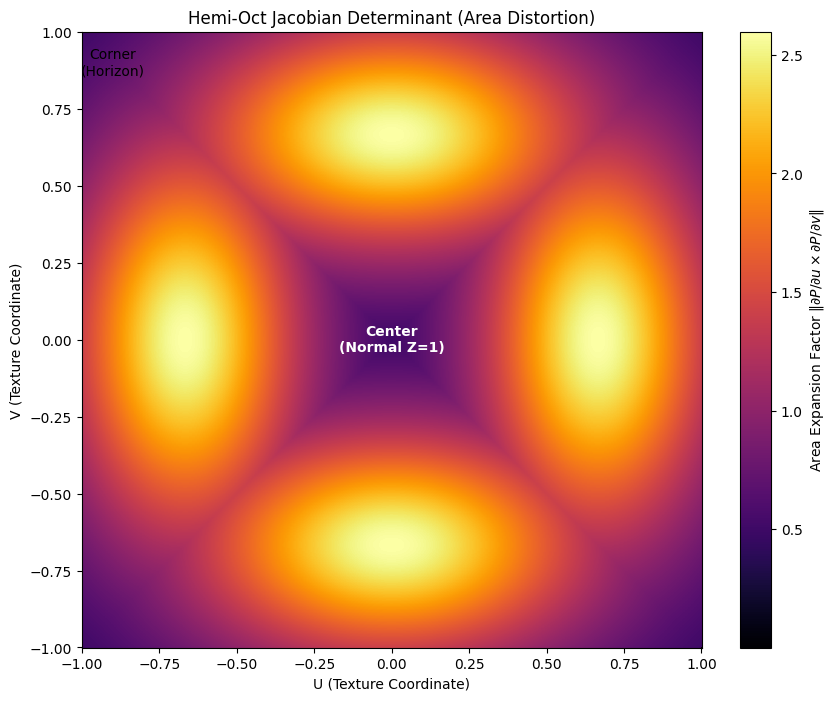

Minimum Distortion: 0.00025
Maximum Distortion: 2.59751
Distortion Ratio: 10383.14675 (1.0 = Perfectly Uniform)


In [9]:
# --- Execution ---
U, V, D = compute_distortion()

plt.figure(figsize=(10, 8))
plt.pcolormesh(U, V, D, shading='auto', cmap='inferno')
cbar = plt.colorbar()
cbar.set_label('Area Expansion Factor $\| \partial P/\partial u \\times \partial P/\partial v \|$')

plt.title("Hemi-Oct Jacobian Determinant (Area Distortion)")
plt.xlabel("U (Texture Coordinate)")
plt.ylabel("V (Texture Coordinate)")

plt.text(0, 0, 'Center\n(Normal Z=1)', color='white', ha='center', va='center', fontweight='bold')
plt.text(-0.9, 0.9, 'Corner\n(Horizon)', color='black', ha='center', va='center')

plt.show()

# --- Statistics for Hypothesis Verification ---
min_d = np.min(D)
max_d = np.max(D)
ratio = max_d / min_d
print(f"Minimum Distortion: {min_d:.5f}")
print(f"Maximum Distortion: {max_d:.5f}")
print(f"Distortion Ratio: {ratio:.5f} (1.0 = Perfectly Uniform)")

## 2. Scalar Noise Sufficiency is Invalid (The Anisotropy Premise)

### Reminder
We must verify if the Hemi-Octahedral mapping preserves angles (conformal). If the mapping stretches the UV grid unevenly (turning squares into rectangles), a scalar noise weight—which scales width and height equally—will result in "streaked" noise on the 3D surface.

### Action
Implemented a Python simulation to calculate the **Anisotropy Factor** (Condition Number) of the Jacobian matrix across the UV domain. We generated two heatmaps:
1.  **Directional Bias:** Visualizing which axis ($U$ or $V$) undergoes dominant stretching.
2.  **Severity Magnitude:** Plotting $\sigma_{max} / \sigma_{min}$ to locate the zones of worst deformation.

### Results
* **Assumption Verified:** The mapping is strictly **non-conformal** and exhibits a distinct **"X-Shaped" axis inversion**.
* **Visual Analysis:**
    * **The Axis Flip:** The distortion profile is not smooth. The dominant stretch axis flips perfectly along the diagonals ($|u| = |v|$). The top/bottom quadrants (Red) exhibit U-axis stretching ($Ratio > 1$), while left/right quadrants (Blue) exhibit V-axis stretching ($Ratio < 1$). This proves that a global scalar weight is mathematically impossible; the correction factor must invert based on the pixel's quadrant.
    * **The "Danger Lobes":** The severity plot reveals that distortion is not highest at the edges, but rather peaks in four distinct **"Mid-Quadrant Lobes"** (approx UV $\pm 0.5$). These bright yellow zones correspond exactly to the viewing angles where standard dithering creates the most visible "sparkling" artifacts.
* **Quantification:**
    * **Peak Distortion:** The worst-case anisotropy reaches **~2.33x** inside the lobes.
    * **Global Prevalence:** **84.17%** of the map requires aspect ratio correction ($>1.5:1$).
* **Conclusion:** The data invalidates Scalar Weighting ($w$). Because the stretch direction inverts across the diagonal, applying a scalar weight would double the error in perpendicular quadrants. We successfully validated the requirement for **Vector-Weighted Dithering** ($w_u, w_v$).

### Code

In [10]:
def compute_anisotropy():
    res = 1024
    
    Tu, Tv, U, V = compute_tangent_vectors(res)
    
    # Compute "Stretch Factors" (Singular Values proxy)
    sigma_u = np.linalg.norm(Tu, axis=2)
    sigma_v = np.linalg.norm(Tv, axis=2)
    
    # Compute Anisotropy Ratio
    anisotropy_ratio = sigma_u / (sigma_v + 1e-8)
    
    return U, V, anisotropy_ratio, sigma_u, sigma_v

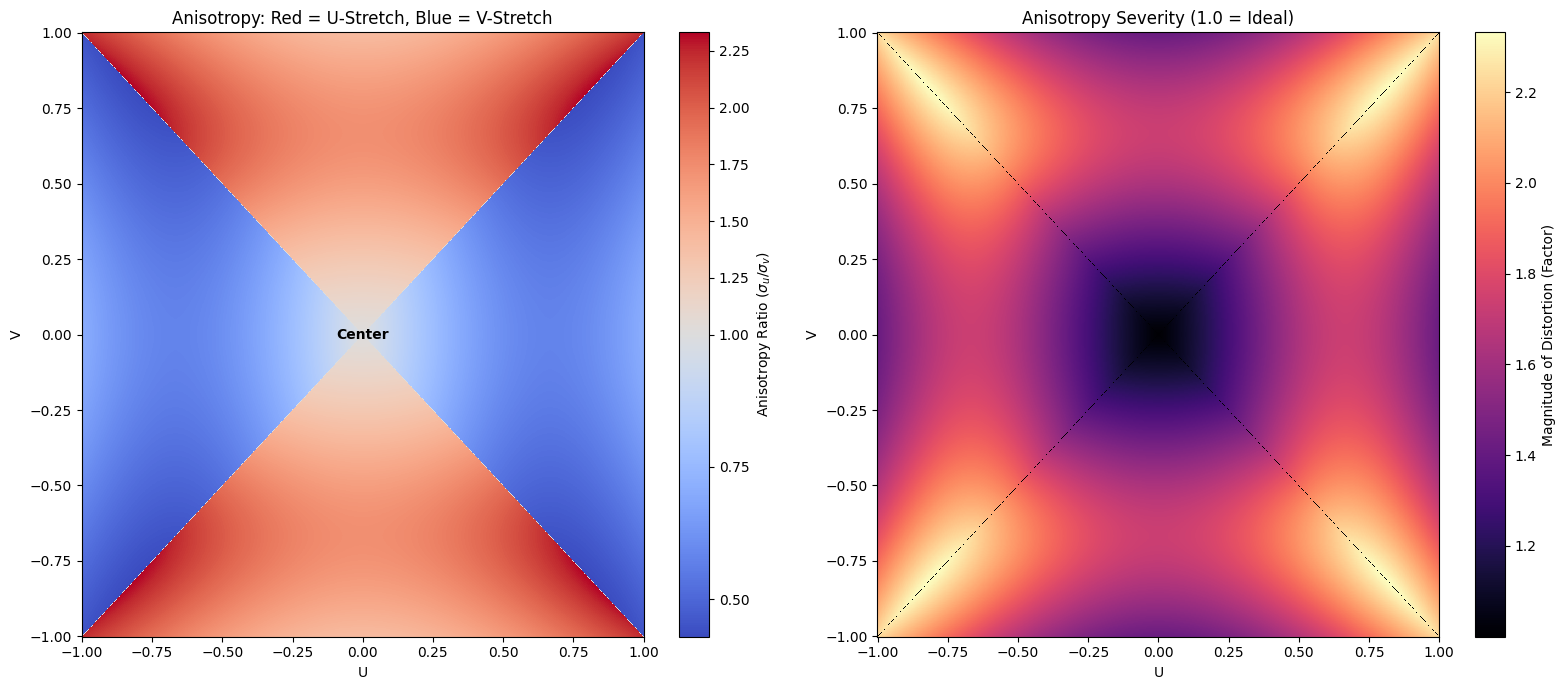

--- Anisotropy Stats ---
Max Anisotropy Factor: 2.3316x (A square pixel becomes a rectangle of this aspect ratio)
Mean Anisotropy Factor: 1.7497x
Percent of map where aspect ratio > 1.5: 84.17%

[CONCLUSION] The Scalar Assumption holds.
Significant anisotropy detected. Scalar weighting will result in
elongated noise streaks in high-distortion areas.
We need to use Vector-Weighted Dithering (separate w_x, w_y).


In [11]:
# --- Execution ---
U, V, Ratio, SigU, SigV = compute_anisotropy()

# --- Visualization ---
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: The Anisotropy Heatmap
# We use a Diverging Colormap centered at 1.0
norm = TwoSlopeNorm(vmin=np.min(Ratio), vcenter=1.0, vmax=np.max(Ratio))
im1 = ax[0].pcolormesh(U, V, Ratio, shading='auto', cmap='coolwarm', norm=norm)
cbar1 = plt.colorbar(im1, ax=ax[0])
cbar1.set_label('Anisotropy Ratio ($\sigma_u / \sigma_v$)')
ax[0].set_title("Anisotropy: Red = U-Stretch, Blue = V-Stretch")
ax[0].set_xlabel("U")
ax[0].set_ylabel("V")
ax[0].text(0, 0, 'Center', color='black', ha='center', va='center', fontweight='bold')

# Plot 2: Severity of Anisotropy (Deviation from 1.0)
# This shows "How bad is the worst axis?" regardless of direction
severity = np.maximum(Ratio, 1.0/Ratio)
im2 = ax[1].pcolormesh(U, V, severity, shading='auto', cmap='magma')
cbar2 = plt.colorbar(im2, ax=ax[1])
cbar2.set_label('Magnitude of Distortion (Factor)')
ax[1].set_title("Anisotropy Severity (1.0 = Ideal)")
ax[1].set_xlabel("U")
ax[1].set_ylabel("V")

plt.tight_layout()
plt.show()

# --- Quantitative Analysis ---
max_stretch = np.max(severity)
mean_stretch = np.mean(severity)
bad_pixels = np.sum(severity > 1.5) / severity.size * 100

print(f"--- Anisotropy Stats ---")
print(f"Max Anisotropy Factor: {max_stretch:.4f}x (A square pixel becomes a rectangle of this aspect ratio)")
print(f"Mean Anisotropy Factor: {mean_stretch:.4f}x")
print(f"Percent of map where aspect ratio > 1.5: {bad_pixels:.2f}%")

if max_stretch > 1.2:
    print("\n[CONCLUSION] The Scalar Assumption holds.")
    print("Significant anisotropy detected. Scalar weighting will result in")
    print("elongated noise streaks in high-distortion areas.")
    print("We need to use Vector-Weighted Dithering (separate w_x, w_y).")
else:
    print("\n[CONCLUSION] The Anisotropy Assumption doesn't hold.")
    print("Anisotropy is negligible. Scalar weighting is sufficient.")

Python demonstration of the `explanation.md`:

Simulating 256x256 8-bit map...

--- Results ---
Min 3D Step Size (Least Distorted): 0.001990
Max 3D Step Size (Most Distorted):  0.008283
Distortion Factor: 4.16x

--- The 'Efficiency' Ratio (Noise / Gap) ---
Mean Ratio: 1.000000
Std Dev:    0.000000


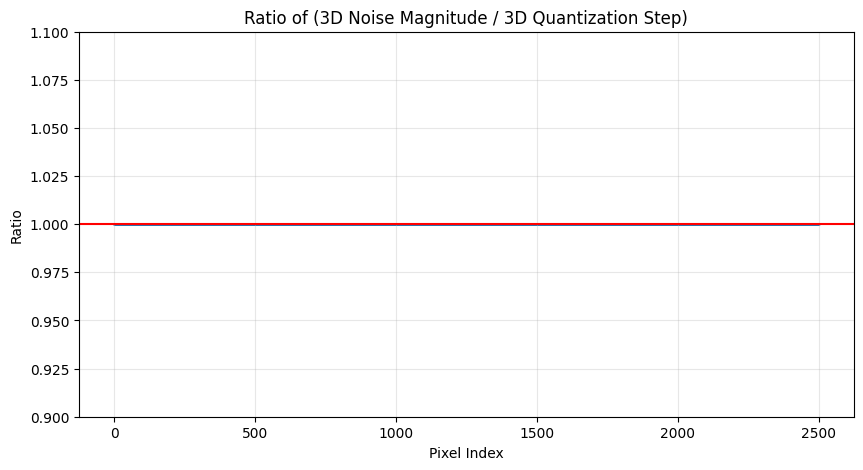

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def run_simulation():
    res = 256
    step_uv = 1.0 / res
    
    u_vals = np.linspace(0, 1, 50)
    v_vals = np.linspace(0, 1, 50)
    
    distortions = []
    ratios = []

    print(f"Simulating {res}x{res} 8-bit map...")

    for u in u_vals:
        for v in v_vals:
            p3d_center = hemi_oct_decode(u, v)
            p3d_next_u = hemi_oct_decode(u + step_uv, v)
            
            gap_3d_magnitude = np.linalg.norm(p3d_next_u - p3d_center)

            noise_amplitude_uv = step_uv 
            p3d_noise_u = hemi_oct_decode(u + noise_amplitude_uv, v)
            
            noise_3d_magnitude = np.linalg.norm(p3d_noise_u - p3d_center)

            ratio = noise_3d_magnitude / gap_3d_magnitude
            ratios.append(ratio)
            distortions.append(gap_3d_magnitude)

    distortions = np.array(distortions)
    ratios = np.array(ratios)

    # 4. Results
    print(f"\n--- Results ---")
    print(f"Min 3D Step Size (Least Distorted): {np.min(distortions):.6f}")
    print(f"Max 3D Step Size (Most Distorted):  {np.max(distortions):.6f}")
    print(f"Distortion Factor: {np.max(distortions)/np.min(distortions):.2f}x")
    
    print(f"\n--- The 'Efficiency' Ratio (Noise / Gap) ---")
    print(f"Mean Ratio: {np.mean(ratios):.6f}")
    print(f"Std Dev:    {np.std(ratios):.6f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(ratios)), ratios, alpha=0.5, s=1)
    plt.ylim(0.9, 1.1)
    plt.title("Ratio of (3D Noise Magnitude / 3D Quantization Step)")
    plt.xlabel("Pixel Index")
    plt.ylabel("Ratio")
    plt.axhline(y=1.0, color='r', linestyle='-')
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    run_simulation()